Inspired from this article: https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
pd.set_option('max_columns', 100)

In [9]:
df= pd.read_csv('dfValid_Xexog_y.csv')
df.head(10)

,#LineFullDataSet,Timestamp,AirHumidity,AirPressure,AirTemperature,GasCHRatio,GasCO2Concentration,GasEthaneConcentration,GasHexaneConcentration,GasHhvEnergy,GasIbutaneConcentration,GasIpentaneConcentration,GasLhvEnergy,GasMethaneConcentration,GasN2Concentration,GasNbutaneConcentration,GasNeopentaneConcentration,GasNpentaneConcentration,GasPropaneConcentration,GasRelativeDensity,GasWobbeInf,GasWobbeSup,GrossPower,GrossEfficiency
0,1199,2015-03-22 23:00:00,75.3816,1012.2817,24.8828,3.1598,1.2313,4.6452,0.1051,41.2768,0.3387,0.1086,37.4156,86.7568,4.3819,0.4345,0.0000,0.0950,1.9655,0.6441,46.4682,51.4018,642.9360,55.8700
1,1200,2015-03-23 00:00:00,70.8406,1011.6278,25.3624,3.1601,1.2304,4.6406,0.1055,41.2755,0.3402,0.1099,37.4546,86.6884,4.3977,0.4365,0.0000,0.0959,1.9643,0.6445,46.4546,51.3817,648.5458,56.5276
2,1201,2015-03-23 01:00:00,67.6830,1011.1119,25.8485,3.1604,1.2422,4.6279,0.1045,41.2742,0.3439,0.1112,37.2963,86.6636,4.3992,0.4393,0.0000,0.0964,1.9790,0.6450,46.4452,51.3719,629.6018,56.9239
3,1202,2015-03-23 02:00:00,63.9178,1010.5114,25.7762,3.1607,1.2473,4.6186,0.1061,41.2730,0.3461,0.1125,37.2876,86.6502,4.4351,0.4443,0.0000,0.0990,1.9698,0.6453,46.4300,51.3558,629.8790,56.8776
4,1203,2015-03-23 03:00:00,55.9751,1010.1195,25.8681,3.1610,1.2383,4.6043,0.1105,41.2013,0.3472,0.1138,37.2789,86.6489,4.5000,0.4484,0.0000,0.1006,1.9538,0.6451,46.4192,51.3353,646.4989,57.0868
5,1204,2015-03-23 04:00:00,57.7673,1010.1570,26.0525,3.1606,1.2280,4.5899,0.1119,41.2051,0.3452,0.1139,37.2724,86.6895,4.4855,0.4465,0.0000,0.1009,1.9435,0.6448,46.4115,51.3397,620.9076,57.1226
6,1205,2015-03-23 05:00:00,56.6081,1010.4600,24.8828,3.1600,1.2178,4.5785,0.1119,41.2089,0.3438,0.1128,37.2868,86.6670,4.4710,0.4378,0.0000,0.1003,1.9476,0.6450,46.4138,51.3507,643.7215,57.2247
7,1206,2015-03-23 06:00:00,54.5935,1011.4798,25.1406,3.1602,1.2075,4.5834,0.1126,41.2128,0.3422,0.1121,37.2559,86.7026,4.4668,0.4417,0.0000,0.0991,1.9407,0.6447,46.4207,51.3502,524.5518,55.9692
8,1207,2015-03-23 07:00:00,58.9554,1011.8895,25.1380,3.1604,1.1820,4.5985,0.1117,41.2446,0.3431,0.1117,37.2852,86.6809,4.4806,0.4371,0.0000,0.0990,1.9459,0.6447,46.4280,51.3558,511.1499,55.3503
9,1208,2015-03-23 08:00:00,64.6285,1013.0113,26.5582,3.1610,1.1756,4.6150,0.1086,41.2639,0.3445,0.1111,37.3024,86.6469,4.4891,0.4457,0.0000,0.0994,1.9617,0.6450,46.4354,51.3604,597.9896,57.0813


In [10]:
df.columns

Index(['#LineFullDataSet', 'Timestamp', 'AirHumidity', 'AirPressure',
       'AirTemperature', 'GasCHRatio', 'GasCO2Concentration',
       'GasEthaneConcentration', 'GasHexaneConcentration', 'GasHhvEnergy',
       'GasIbutaneConcentration', 'GasIpentaneConcentration', 'GasLhvEnergy',
       'GasMethaneConcentration', 'GasN2Concentration',
       'GasNbutaneConcentration', 'GasNeopentaneConcentration',
       'GasNpentaneConcentration', 'GasPropaneConcentration',
       'GasRelativeDensity', 'GasWobbeInf', 'GasWobbeSup', 'GrossPower',
       'GrossEfficiency'],
      dtype='object')

The following data pre-processing and feature engineering steps need to be done:
Merge Date & Time into one column and change to datetime type.
1) Convert Global_active_power to numeric and remove missing values (1.2%).

2) Create year, quarter, month and day features.

3) Create weekday feature, “0” is weekend and “1” is weekday.

In [11]:
df['GrossEfficiency'] = pd.to_numeric(df['GrossEfficiency'], errors='coerce')
df['date_time'] = pd.to_datetime(df['Timestamp'] )
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)

df=df.loc[:,['date_time', 'GrossEfficiency' ,'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (4517, 7)
The time series starts from:  2015-03-22 23:00:00
The time series ends on:  2015-11-17 10:00:00


## Statistical Normality Test

In the SciPy implementation of the test, we will interpret the p value as follows.
>p <= alpha: reject H0, not normal.

>p > alpha: fail to reject H0, normal.

In [12]:
stat, p = stats.normaltest(df.GrossEfficiency)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=3204.115, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate **Kurtosis** and **Skewness**, to determine if the data distribution departs from the normal distribution.

**Kurtosis** : describes heaviness of the tails of a distribution
Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

**Skewness** : measures asymmetry of the distribution

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

Kurtosis of normal distribution: 17.649903707199304
Skewness of normal distribution: -3.1592394266952444


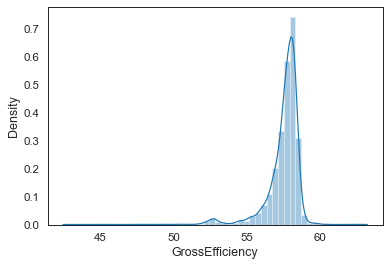

In [14]:
sns.distplot(df.GrossEfficiency);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.GrossEfficiency)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.GrossEfficiency)))

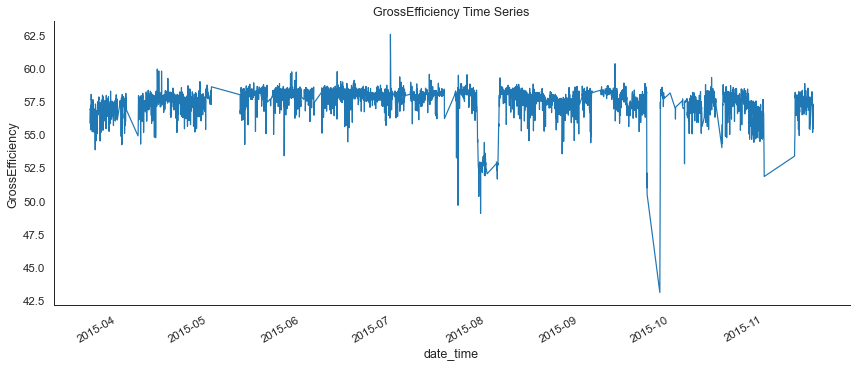

In [16]:
df1=df.loc[:,['date_time','GrossEfficiency']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('GrossEfficiency')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('GrossEfficiency Time Series')
sns.despine(top=True)
plt.show();

,count,mean,std,min,25%,50%,75%,max
GrossEfficiency,4517.0000,57.4996,1.1299,43.0659,57.2522,57.7767,58.1385,62.5828


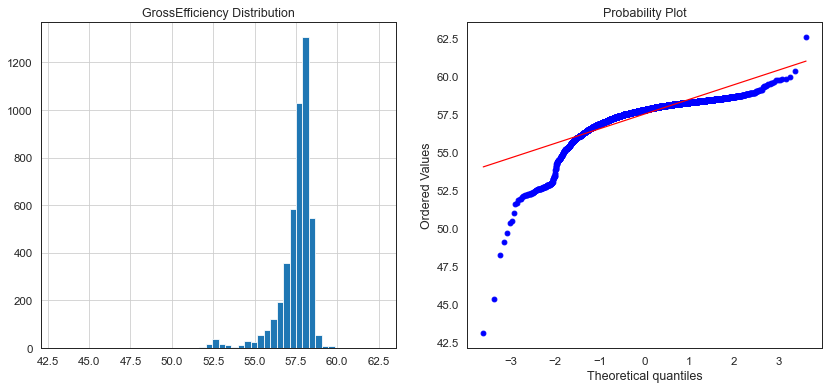

In [17]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['GrossEfficiency'].hist(bins=50)
plt.title('GrossEfficiency Distribution')
plt.subplot(1,2,2)
stats.probplot(df['GrossEfficiency'], plot=plt);
df1.describe().T

# Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

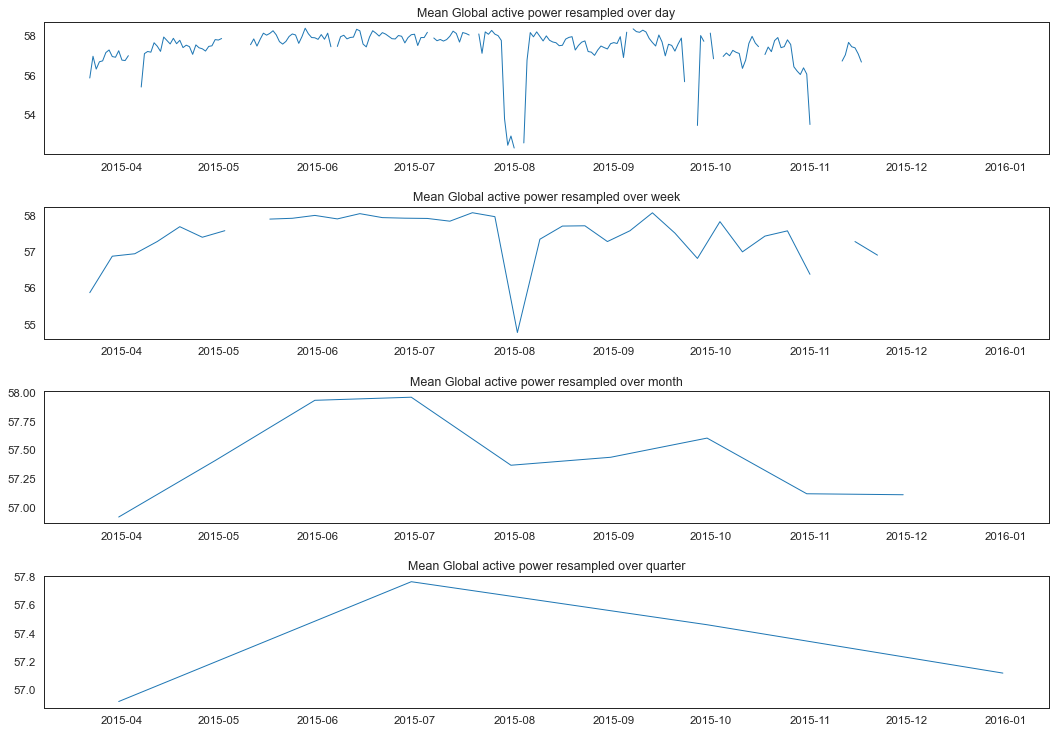

In [19]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['GrossEfficiency'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['GrossEfficiency'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['GrossEfficiency'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['GrossEfficiency'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')


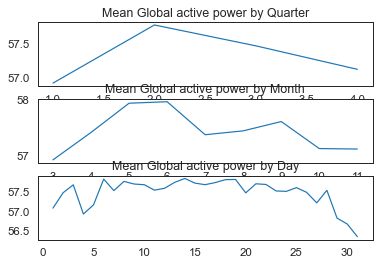

In [23]:


plt.subplot(3,1,1)
df.groupby('quarter').GrossEfficiency.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(3,1,2)
df.groupby('month').GrossEfficiency.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(3,1,3)
df.groupby('day').GrossEfficiency.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

Dickey-Fuller test
- Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
- p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

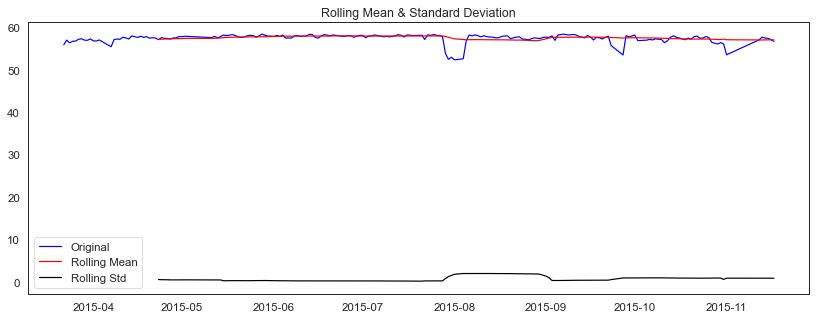

<Results of Dickey-Fuller Test>
Test Statistic                 -5.9778
p-value                         0.0000
#Lags Used                      0.0000
Number of Observations Used   206.0000
Critical Value (1%)            -3.4625
Critical Value (5%)            -2.8757
Critical Value (10%)           -2.5743
dtype: float64


In [29]:
df2=df1.resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.GrossEfficiency.dropna())

multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

data pre-processing and feature engineering need to be done before construct the LSTM model.
Create the dataset, ensure all data is float.
- Normalize the features.
- Split into training and test sets.
- Convert an array of values into a dataset matrix.
- Reshape into X=t and Y=t+1.
- Reshape input to be 3D (num_samples, num_timesteps, num_features).


In [45]:
dataset = df.GrossEfficiency.values #numpy.ndarray
dataset = dataset.astype('float32')

dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Model Architecture
- Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. The input shape will be 1 time step with 30 features.
- Dropout 20%.
- Use the MSE loss function and the efficient Adam version of stochastic gradient descent.
- The model will be fit for 20 training epochs with a batch size of 70.

In [47]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=2, shuffle=False)

model.summary()

Epoch 1/100
52/52 - 4s - loss: 0.0346 - val_loss: 0.0038 - 4s/epoch - 74ms/step
Epoch 2/100
52/52 - 0s - loss: 0.0046 - val_loss: 0.0038 - 158ms/epoch - 3ms/step
Epoch 3/100
52/52 - 0s - loss: 0.0042 - val_loss: 0.0037 - 165ms/epoch - 3ms/step
Epoch 4/100
52/52 - 0s - loss: 0.0042 - val_loss: 0.0037 - 170ms/epoch - 3ms/step
Epoch 5/100
52/52 - 0s - loss: 0.0038 - val_loss: 0.0037 - 168ms/epoch - 3ms/step
Epoch 6/100
52/52 - 0s - loss: 0.0034 - val_loss: 0.0036 - 179ms/epoch - 3ms/step
Epoch 7/100
52/52 - 0s - loss: 0.0034 - val_loss: 0.0036 - 166ms/epoch - 3ms/step
Epoch 8/100
52/52 - 0s - loss: 0.0032 - val_loss: 0.0036 - 171ms/epoch - 3ms/step
Epoch 9/100
52/52 - 0s - loss: 0.0031 - val_loss: 0.0035 - 166ms/epoch - 3ms/step
Epoch 10/100
52/52 - 0s - loss: 0.0031 - val_loss: 0.0035 - 180ms/epoch - 3ms/step
Epoch 11/100
52/52 - 0s - loss: 0.0029 - val_loss: 0.0034 - 158ms/epoch - 3ms/step
Epoch 12/100
52/52 - 0s - loss: 0.0028 - val_loss: 0.0035 - 172ms/epoch - 3ms/step
Epoch 13/100
52

# Make Predictions

In [48]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.4711015071877635
Train Root Mean Squared Error: 0.7028189260229515
Test Mean Absolute Error: 0.6700592688253951
Test Root Mean Squared Error: 1.0863878726647254


# Plot Model Loss

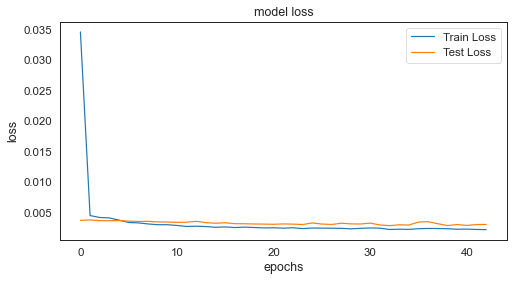

In [49]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# Compare Actual vs. Prediction

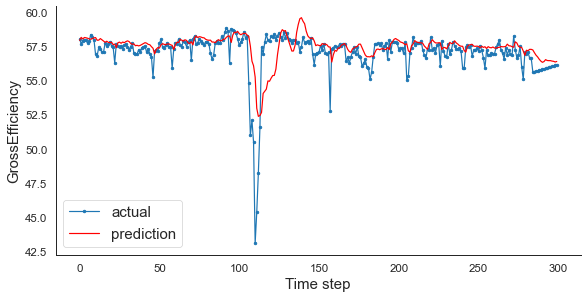

In [50]:
aa=[x for x in range(300)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:300], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:300], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('GrossEfficiency', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();